In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

#### Data effect

In [2]:
# Load data dir
dir = '/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/'
# Save data dir
dir_save = '/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/newdata3/'

# dataframe containing VTAs for prediction
data_HDP_VTAmasive = pd.read_csv(dir + 'data_HDP_VTAmassive.csv')
data_CST_VTAmasive  = pd.read_csv(dir + 'data_CST_VTAmassive.csv')

# dataframe containing clinical mA
clinical_mA_ef = pd.read_csv(dir + 'clinical_mA_effect.csv')
clinical_mA_sef = pd.read_csv(dir + 'clinical_mA_side_effect_capsular.csv')

#total sum weights
sum_w_CST = pd.read_csv(dir + 'df_total_sum_w_CST_3.csv')
sum_w_HDP = pd.read_csv(dir + 'df_total_sum_w_HDP.csv')

In [3]:
# Remove 'non tested contacts' (0 mA) & 'non effect contacts' (8 mA)
#clinical_mA_HDP = clinical_mA_ef[(clinical_mA_ef['mA'] > 0) & (clinical_mA_ef['mA'] < 8)]
#clinical_mA_CST = clinical_mA_sef[(clinical_mA_sef['mA_capsular'] > 0) & (clinical_mA_sef['mA_capsular'] < 8)]

# Remove only non tested contacts --> data saved in /newdata2
clinical_mA_HDP = clinical_mA_ef[(clinical_mA_ef['mA'] > 0)]
clinical_mA_CST = clinical_mA_sef[(clinical_mA_sef['mA_capsular'] > 0)]
clinical_mA_CST.drop('mA_capsular', axis=1, inplace=True)

# Filter data to keep only tested contacts
data_HDP = pd.merge(data_HDP_VTAmasive, clinical_mA_HDP, how="inner", on=['LeadID', 'ContactID', 'mA'])
data_CST = pd.merge(data_CST_VTAmasive, clinical_mA_CST, how="inner", on=['LeadID', 'ContactID', 'mA'])

# Add outcome & pathway columns
data_HDP['outcome'] = 1
data_HDP['pathway'] = 'HDP'
data_CST['outcome'] = 1
data_CST['pathway'] = 'CST'

/home/alba/PycharmProjects/HDP/venv/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Data no effect

In [4]:
# Get no effect data from all subjects
# Create empty dataframes
df_fbc_Nef = pd.DataFrame(columns=['contact', 'name', 'count', 'total_count', 'percent', 'sum_w', 'fbc', 'path'])
df_fbc_Nsef = pd.DataFrame(columns=['contact', 'name', 'count', 'total_count', 'percent', 'sum_w', 'fbc', 'path'])

# loop in "subjects" folder to repeat process for each subject
rootdir = '/mnt/data/2020_Projects/2021_HDP/03_Data/subjects/'
entries = Path(rootdir)

for entry in sorted(entries.iterdir()):  # each entry is one of the subjects' subfolder
    #print(entry.name)
    # LOAD DATA FROM .csv FILES
    for file in entry.glob('**/ne_effect.csv'):
        df_ne_effect = pd.read_csv(file)  # dataframe ne_effect

    for file in entry.glob('**/df_ne_CST_3.csv'):
        df_ne_side_effect = pd.read_csv(file)  # dataframe ne_side_effect

    # Append obtained fbc values to dataframes
    df_fbc_Nef = df_fbc_Nef.append(df_ne_effect[['contact', 'name', 'count', 'total_count', 'percent', 'sum_w', 'fbc', 'path']], ignore_index=True)
    df_fbc_Nsef = df_fbc_Nsef.append(df_ne_side_effect[['contact', 'name', 'count', 'total_count', 'percent', 'sum_w', 'fbc', 'path']], ignore_index=True)

In [5]:
df_fbc_Nsef['name'] = df_fbc_Nsef['name'].replace('_3', '', regex=True) # modify name in CST so position of L/R is the same

# Merge both dataframes to add new columns at the same time
df = pd.concat([df_fbc_Nef, df_fbc_Nsef], axis=0)

# Keep only numerical values from contact
df['contact'] = df['contact'].replace('ne', '', regex=True)

# Add new column with lead L/R
df['lead'] = pd.DataFrame(df.name.str.split('_').str[2])  # split entry in substrings and keep the one in position 2

# Create empty column
df['C'] = ""
maskL = (df['lead'] == 'L')  # if 'L' in column lead
df['C'][maskL] = (df.contact.str.split('-|_').str[0])  # keep contactID in first position [0] --> left contact)
maskR = (df['lead'] == 'R')  # if 'R' in column lead
df['C'][maskR] = (df.contact.str.split('-|_').str[1])  # keep contactID in second position [1] --> right contact)

# Add new columns with LeadID & ContactID
df['LeadID'] = pd.DataFrame((df.path.str.split('/').str[7]).map(str) + '_' + df.lead)
df['ContactID'] = pd.DataFrame((df.path.str.split('/').str[7]).map(str) + '_' + df.C)

# Add total_sum_w column
# from total_sum_w  --> dataframes created in 'total_sum_w.py'
# split df according to pathway
df_ne_HDP = df[df['name'].str.contains('STN')]
df_ne_CST = df[df['name'].str.contains('CST')]

# extract colums as lists and create dictionaries
LeadID_HDP = sum_w_HDP['LeadID'].to_list()
total_sum_w_HDP = sum_w_HDP['total_sum_w'].to_list()
dict_sum_w_HDP = dict(zip(LeadID_HDP, total_sum_w_HDP))

LeadID_CST = sum_w_CST['LeadID'].to_list()
total_sum_w_CST = sum_w_CST['total_sum_w'].to_list()
dict_sum_w_CST = dict(zip(LeadID_CST, total_sum_w_CST))

# use dictionaries for creating new column total_sum_w and percent_w
df_ne_HDP['total_sum_w'] = df_ne_HDP['LeadID'].map(dict_sum_w_HDP)
df_ne_HDP['percent_w'] = df_ne_HDP['sum_w']*100/df_ne_HDP['total_sum_w']

df_ne_CST['total_sum_w'] = df_ne_CST['LeadID'].map(dict_sum_w_CST)
df_ne_CST['percent_w'] = df_ne_CST['sum_w']*100/df_ne_CST['total_sum_w']

data_ne_HDP = df_ne_HDP[['LeadID', 'ContactID', 'count', 'total_count', 'percent', 'sum_w', 'total_sum_w', 'percent_w', 'fbc']]
data_ne_CST = df_ne_CST[['LeadID', 'ContactID', 'count', 'total_count', 'percent', 'sum_w', 'total_sum_w', 'percent_w', 'fbc']]

# Filter data to keep only tested contacts
data_ne_HDP = pd.merge(data_ne_HDP, clinical_mA_HDP, how="inner", on=['LeadID', 'ContactID'])
data_ne_CST = pd.merge(data_ne_CST, clinical_mA_CST, how="inner", on=['LeadID', 'ContactID'])

# Add outcome & pathway columns
data_ne_HDP['outcome'] = 0
data_ne_HDP['pathway'] = 'HDP'
data_ne_CST['outcome'] = 0
data_ne_CST['pathway'] = 'CST'

/home/alba/PycharmProjects/HDP/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/alba/PycharmProjects/HDP/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alba/PycharmProjects/HDP/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

compare VTAs at no effect with the VTAs from massive at 1 mA, to avoid that they have a larger VTA (saved in newdata3)
instead of directly comparing with the VTAs at effect (saved in newdata2)
this might improve the accuracy of the model, as in some cases DaHa10 seems to be a problem

#### Merge data and save

In [6]:
# Add mA column in no effect to concatenate dataframes
data_ne_HDP['mA'] = 0
data_ne_CST['mA'] = 0

df_HDP = pd.concat([data_HDP, data_ne_HDP], axis=0)
df_CST = pd.concat([data_CST, data_ne_CST], axis=0)

In [ ]:
df_HDP.to_csv(dir_save + 'data_HDP.csv', index=False)
df_CST.to_csv(dir_save + 'data_CST.csv', index=False)

#### Set to 0 values where VTA no effect > VTA effect 1mA

In [7]:
# Get VTAs at 1mA
data_HDP_1 = data_HDP_VTAmasive.loc[data_HDP_VTAmasive['mA'] == 1]
data_CST_1 = data_CST_VTAmasive.loc[data_CST_VTAmasive['mA'] == 1]
# filter to keep only the ones in clinical
data_HDP_1 = pd.merge(data_HDP_1, clinical_mA_HDP[['LeadID', 'ContactID']], how="inner", on=['LeadID', 'ContactID'])
data_CST_1 = pd.merge(data_CST_1, clinical_mA_CST[['LeadID', 'ContactID']], how="inner", on=['LeadID', 'ContactID'])

In [8]:
# Add compare_percent column in df_no_effect
data_ne_HDP['Compare_percent'] = np.where(data_HDP_1.percent_w > data_ne_HDP.percent_w, 'True', 'False')
data_ne_CST['Compare_percent'] = np.where(data_CST_1.percent_w > data_ne_CST.percent_w, 'True', 'False')

In [9]:
data_ne_HDP.loc[(data_ne_HDP['Compare_percent'] == 'False') & (data_ne_HDP['percent_w'] != 0)]

LeadID ContactID count total_count    percent      sum_w  total_sum_w  \
2    BaHe_L    BaHe_5     1         251   0.398406   0.809004   283.475410   
3    BaHe_L  BaHe_567     2         251   0.796813   1.593333   283.475410   
4    BaHe_L    BaHe_6    17         251   6.772908  17.734764   283.475410   
5    BaHe_L    BaHe_7     3         251   1.195219   3.045359   283.475410   
6    BaHe_L    BaHe_8     8         251   3.187251   8.652805   283.475410   
..      ...       ...   ...         ...        ...        ...          ...   
269  WiDa_L    WiDa_6     3         168   1.785714   3.809124   218.817640   
270  WiDa_R   WiDa_14     1          40   2.500000   0.861971    48.748791   
271  WiDa_L    WiDa_7     8         168   4.761905   8.993472   218.817640   
272  WiDa_R   WiDa_15     4          40  10.000000   3.913693    48.748791   
274  WiDa_R   WiDa_16     5          40  12.500000   4.727060    48.748791   

     percent_w       fbc  mA  outcome pathway Compare_percent  
2     0.285388  0.000027   0        0     HDP           False  
3     0.562071  0.000053   0        0     HDP           False  
4     6.256191  0.000593   0        0     HDP           False  
5     1.074294  0.000102   0        0     HDP           False  
6     3.052401  0.000289   0        0     HDP           False  
..         ...       ...  ..      ...     ...             ...  
269   1.740776  0.000163   0        0     HDP           False  
270   1.768189  0.000037   0        0     HDP           False  
271   4.110031  0.000386   0        0     HDP           False  
272   8.028288  0.000168   0        0     HDP           False  
274   9.696774  0.000203   0        0     HDP           False  

[125 rows x 13 columns]

In [27]:
#data_ne_CST.loc[data_ne_CST['Compare_percent'] == 'False']
data_ne_CST.loc[(data_ne_CST['Compare_percent'] == 'False') & (data_ne_CST['percent_w'] != 0)]

LeadID    ContactID count total_count   percent      sum_w  total_sum_w  \
6    BaHe_L       BaHe_7     1        1197  0.083542   1.188494  1469.556929   
10   BoPa_R       BoPa_9     3        3040  0.098684   3.668384  3601.980572   
12   BoPa_R  BoPa_101112     5        3040  0.164474   5.946684  3601.980572   
39   DaHa_L       DaHa_2    39        6518  0.598343  56.958261  9241.239372   
40   DaHa_R      DaHa_10     2        5925  0.033755   2.616526  8211.337377   
..      ...          ...   ...         ...       ...        ...          ...   
276  WiDa_R      WiDa_14    31        3730  0.831099  33.219251  4922.619923   
277  WiDa_L       WiDa_7     9        2618  0.343774   9.737590  3181.629780   
278  WiDa_R      WiDa_15    16        3730  0.428954  17.946339  4922.619923   
279  WiDa_L       WiDa_8     5        2618  0.190985   5.402747  3181.629780   
280  WiDa_R      WiDa_16    20        3730  0.536193  22.882720  4922.619923   

     percent_w       fbc  mA  outcome pathway Compare_percent  
6     0.080874  0.000040   0        0     CST           False  
10    0.101844  0.000135   0        0     CST           False  
12    0.165095  0.000220   0        0     CST           False  
39    0.616349  0.001902   0        0     CST           False  
40    0.031865  0.000087   0        0     CST           False  
..         ...       ...  ..      ...     ...             ...  
276   0.674829  0.001426   0        0     CST           False  
277   0.306057  0.000418   0        0     CST           False  
278   0.364569  0.000770   0        0     CST           False  
279   0.169811  0.000232   0        0     CST           False  
280   0.464848  0.000982   0        0     CST           False  

[123 rows x 13 columns]

In [11]:
# Set to 0 columns where VTA ne effect > VTA effect 1mA
data_ne_HDP.loc[( (data_ne_HDP['Compare_percent'] == 'False') & (data_ne_HDP['percent_w'] != 0) ), ('percent', 'sum_w', 'percent_w', 'fbc')] = 0
data_ne_CST.loc[( (data_ne_CST['Compare_percent'] == 'False') & (data_ne_CST['percent_w'] != 0) ), ('percent', 'sum_w', 'percent_w', 'fbc')] = 0

In [12]:
# Save data
df_HDP_0 = pd.concat([data_HDP, data_ne_HDP], axis=0)
df_CST_0 = pd.concat([data_CST, data_ne_CST], axis=0)

df_HDP_0.to_csv(dir_save + 'data_HDP_0.csv', index=False)
df_CST_0.to_csv(dir_save + 'data_CST_0.csv', index=False)

## No effect 0 mA

In [4]:
# Keep only VTAs at effect
data_HDP_ef = data_HDP[(data_HDP.mA < 8)].reset_index(drop=True)
data_CST_ef = data_CST[(data_CST.mA < 8)].reset_index(drop=True)

In [8]:
HDP_0 = pd.DataFrame(0, index=np.arange(len(data_HDP_ef)), columns=['mA','count','total_count','percent','sum_w','total_sum_w','percent_w','fbc', 'outcome'])

HDP_0 = pd.concat([data_HDP_ef[['LeadID','ContactID']], HDP_0], axis=1)
HDP_0['pathway'] = 'HDP'

In [9]:
CST_0 = pd.DataFrame(0, index=np.arange(len(data_CST_ef)), columns=['mA','count','total_count','percent','sum_w','total_sum_w','percent_w','fbc', 'outcome'])

CST_0 = pd.concat([data_CST_ef[['LeadID','ContactID']], CST_0], axis=1)
CST_0['pathway'] = 'CST'

In [11]:
# Save data
df_HDP_0mA = pd.concat([data_HDP_ef, HDP_0], axis=0)
df_CST_0mA = pd.concat([data_CST_ef, CST_0], axis=0)

In [12]:
df_HDP_0mA.to_csv(dir_save + 'data_HDP_0mA.csv', index=False)
df_CST_0mA.to_csv(dir_save + 'data_CST_0mA.csv', index=False)

# No effect 0.1 mA

## Plot logreg

In [13]:
# Load data
df_HDP_0 = pd.read_csv('/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/newdata3/data_HDP_0mA.csv')
df_CST_0 = pd.read_csv('/mnt/data/2020_Projects/2021_HDP/03_Data/FBCcalc_simbio_fastfield_20subj/newdata3/data_CST_0mA.csv')

/home/alba/PycharmProjects/HDP/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 241.2x241.2 with 0 Axes>

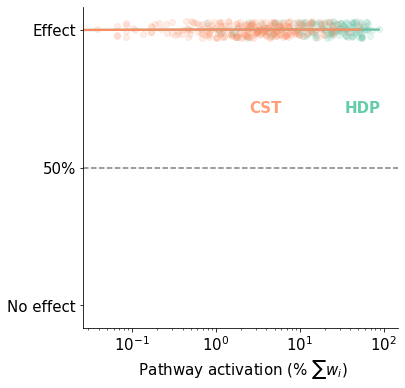

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.concat([df_HDP_0, df_CST_0], axis=0)

plt.figure(figsize=(3.35,3.35))
#plt.style.use('default')
# Plot log reg curves for all data (clinical VTAs)
sns.lmplot(x="percent_w", y="outcome", hue="pathway", data=df,
           logistic=True, y_jitter=.03, palette="Set2", legend=False, scatter_kws={'alpha':0.15} )
plt.xscale('log')
plt.axhline(y=0.5, color='grey', linestyle='--')
#plt.axvline(x=60, color='grey', linestyle='--')
#plt.axvline(x=100, color='grey', linestyle='--')
#plt.axvline(x=1.1, color='grey', linestyle='--')
#plt.axvline(x=4.5, color='grey', linestyle='--')

#plt.title('Activation thresholds')
plt.xlabel ( r' Pathway activation (% $\sum w_i$)' , fontsize=15)
#plt.xlabel ( r' Pathway activation (fbc)' , fontsize=15)
plt.xticks(fontsize=15)
plt.xlim([0, 150])
#plt.ylabel ('Outcome')
plt.ylabel('')
ys=[0,0.5, 1]
labels=['No effect','50%', 'Effect']
plt.yticks(ys, labels, fontsize=15)

plt.text(34,0.7, 'HDP',{'color':'mediumaquamarine','weight':'heavy','size':15})
plt.text(2.5,0.7, 'CST',{'color':'lightsalmon','weight':'heavy','size':15})

#plt.text(0.0003,0.7, 'HDP',{'color':'mediumaquamarine','weight':'heavy','size':15})
#plt.text(0.0043,0.7, 'CST',{'color':'lightsalmon','weight':'heavy','size':15})

#plt.legend(title='Pathway', labels=['HDP', 'CST'], bbox_to_anchor=(0.82, 0.65), loc='upper left', borderaxespad=0)
#plt.legend(title='Pathway', loc='center right', labels=['HDP', 'CST'])

#plt.savefig('/mnt/data/2020_Projects/2021_HDP/03_Data/Plots/logreg_pathways_man.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
df_CST_0.groupby(['outcome'], as_index=False).percent_w.mean()

outcome  percent_w
0        0   0.000000
1        1   5.178159

In [17]:
df_HDP_0.loc[df_HDP_0['outcome'] == 1].percent_w.max()

87.50824403525286